# Real Estate Price Prediction: Neural Network in TensorFlow (Part 2)

Author: **Marcin Sikorski**<br>
Date: January, 2024

The first estimator for price predicting will be an artificial neural network.

**Notebook Content:**
1. Preparing Dataset
2. Training & Evaluating Model
3. Cross-Validation Evaluation
4. Feature Importance

### 1. Preparing Dataset

We will import the previous data from EDA and convert it into NumPy arrays.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('kc_house_data.csv')

dataset = df.values # convert dataframe into array

# divide dataset into feature and target arrays
X = dataset[:, 1:]
y = dataset[:, 0]

print('Feature shape:', X.shape)
print('Target shape:', y.shape)

Feature shape: (21613, 19)
Target shape: (21613,)


The arrays will be transformed with the `MinMaxScaler` and divided into training, testing, and validation subsets.

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# rescale data
def rescale_data(a):
    min_max_scaler = MinMaxScaler()
    return min_max_scaler.fit_transform(a)

X_scale = rescale_data(X)

# divide arrays into: train, test & validation sets
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X_scale, y, test_size=0.3, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, shuffle=True)

print('Feature subsets shapes:')
print('Training:', X_train.shape)
print('Validation:', X_val.shape)
print('Testing:', X_test.shape)

print('\nTarget subsets shapes:')
print('Training:', y_train.shape)
print('Validation:', y_val.shape)
print('Testing:', y_test.shape)

Feature subsets shapes:
Training: (15129, 19)
Validation: (3242, 19)
Testing: (3242, 19)

Target subsets shapes:
Training: (15129,)
Validation: (3242,)
Testing: (3242,)


### 2. Training & Evaluating Model

At this stage, we will setup the regressor. A regularization term will be added to the cost function to avoid over-fitting. The L2 (ridge) term should be a better choice. It is useful for collinear/codependent features in a dataset. L1 is much more useful to shrink the less important feature's coefficient to minimum, thus reducing some variables. In other words, it works well for feature selection in case we have a huge number of features.

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2

# define estimator's architecture
def ann_architecture():
    model = Sequential(
        [
            Dense(19, activation='relu', kernel_regularizer=l2(0.01)),
            Dense(19, activation='relu', kernel_regularizer=l2(0.01)),
            Dense(19, activation='relu', kernel_regularizer=l2(0.01)),
            Dense(19, activation='relu', kernel_regularizer=l2(0.01)),
            Dense(1)
        ], name='estimator'
    )
    
    model.compile(optimizer='adam', loss='mse')
    
    return model

model = ann_architecture()

A customized callback will be implemented to print every 10th log of training process.

In [4]:
from keras.callbacks import Callback

# set new callback
class CustomizeCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (int(epoch) % 10) == 0:
            print(
                f"Epoch: {epoch:>3}/500"
                + f" ~ Loss: {logs['loss']:.4e}"
                + f" ~ Validation loss: {logs['val_loss']:.4e}"
            )

custom_callbacks = [CustomizeCallback()]

In [5]:
# train neural network
model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
                 batch_size=128, epochs=500, verbose=0, callbacks=[custom_callbacks])

Epoch:   0/500 ~ Loss: 3.8332e+11 ~ Validation loss: 3.8860e+11
Epoch:  10/500 ~ Loss: 7.4030e+10 ~ Validation loss: 7.6472e+10
Epoch:  20/500 ~ Loss: 5.4567e+10 ~ Validation loss: 5.4750e+10
Epoch:  30/500 ~ Loss: 3.6280e+10 ~ Validation loss: 3.4856e+10
Epoch:  40/500 ~ Loss: 2.9153e+10 ~ Validation loss: 2.7497e+10
Epoch:  50/500 ~ Loss: 2.4440e+10 ~ Validation loss: 2.2766e+10
Epoch:  60/500 ~ Loss: 2.1466e+10 ~ Validation loss: 1.9943e+10
Epoch:  70/500 ~ Loss: 1.9397e+10 ~ Validation loss: 1.8059e+10
Epoch:  80/500 ~ Loss: 1.7986e+10 ~ Validation loss: 1.6809e+10
Epoch:  90/500 ~ Loss: 1.7050e+10 ~ Validation loss: 1.5944e+10
Epoch: 100/500 ~ Loss: 1.6416e+10 ~ Validation loss: 1.5324e+10
Epoch: 110/500 ~ Loss: 1.6004e+10 ~ Validation loss: 1.4915e+10
Epoch: 120/500 ~ Loss: 1.5664e+10 ~ Validation loss: 1.4634e+10
Epoch: 130/500 ~ Loss: 1.5375e+10 ~ Validation loss: 1.4417e+10
Epoch: 140/500 ~ Loss: 1.5073e+10 ~ Validation loss: 1.4299e+10
Epoch: 150/500 ~ Loss: 1.4808e+10 ~ Vali

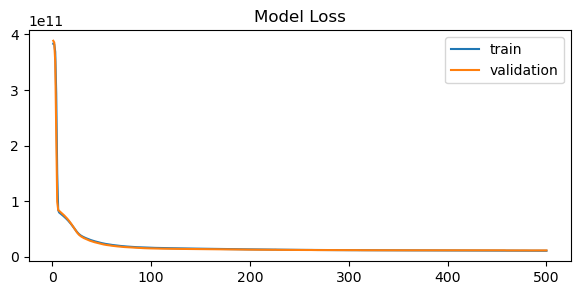

In [6]:
def learning_curves():
    loss = pd.DataFrame(model.history.history)
    epochs = len(loss) + 1
    
    plt.figure(figsize=(7, 3))
    plt.plot(range(1, epochs), loss['loss'], label='train')
    plt.plot(range(1, epochs), loss['val_loss'], label='validation')
    plt.title('Model Loss')
    plt.legend(loc='upper right')
    plt.show()
    
learning_curves()

> These learning curves indicate a very good fit. The generalization gap is very minimum, meaning there is no under-fitting or over-fitting. The curves display a stable learning process.

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

def model_evaluation():
    # testing subset
    print('-------------------------------------------------------------')
    predictions = model.predict(X_test, verbose=1)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmsle = np.sqrt(np.mean(np.power(np.log1p(predictions) - np.log1p(y_test), 2))) # root mean squared logarithmic error
    r2 = r2_score(y_test, predictions)
    adj_r2 = 1 - (1 - r2)*(len(predictions) - 1)/(len(predictions) - X_train.shape[1] - 1)
    ev = explained_variance_score(y_test, predictions)
    
    print('Testing performance:')
    print('RMSE: {:.1f}'.format(rmse))
    print('RMSLE: {:.4f}'.format(rmsle))
    print('R2: {:.4f}'.format(r2))
    print('Adjusted R2: {:.4f}'.format(adj_r2))
    print('Variance regression: {:.4f}'.format(ev))
    
    # training subset
    print('-------------------------------------------------------------')
    predictions = model.predict(X_train, verbose=1)
    
    rmse = np.sqrt(mean_squared_error(y_train, predictions))
    rmsle = np.sqrt(np.mean(np.power(np.log1p(predictions) - np.log1p(y_train), 2)))
    r2 = r2_score(y_train, predictions)
    adj_r2 = 1 - (1 - r2)*(len(predictions) - 1)/(len(predictions) - X_train.shape[1] - 1)
    ev = explained_variance_score(y_train, predictions)

    print('Training performance:')
    print('RMSE: {:.1f}'.format(rmse))
    print('RMSLE: {:.4f}'.format(rmsle))
    print('R2: {:.4f}'.format(r2))
    print('Adjusted R2: {:.4f}'.format(adj_r2))
    print('Variance regression: {:.4f}'.format(ev))
    
model_evaluation()

-------------------------------------------------------------
102/102 [==============================] - 0s 1ms/step
Testing performance:
RMSE: 110582.6
RMSLE: 0.7188
R2: 0.8819
Adjusted R2: 0.8812
Variance regression: 0.8837
-------------------------------------------------------------
473/473 [==============================] - 1s 1ms/step
Training performance:
RMSE: 105706.9
RMSLE: 0.7093
R2: 0.8879
Adjusted R2: 0.8877
Variance regression: 0.8892


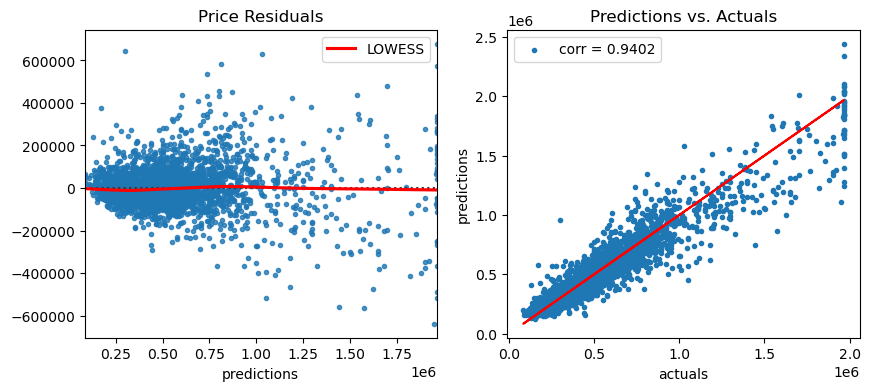

In [8]:
from seaborn import residplot

def plot_residuals():
    predictions = model.predict(X_test, verbose=0)
    fig = plt.figure(figsize=(10, 4))
    
    # no clear pattern indicates that the linear approximation is appropriate
    plt.subplot(1, 2, 1)
    plot = residplot(x=y_test, y=predictions, lowess=True, line_kws={'color': 'red', 'label': 'LOWESS'},
                     scatter_kws={'marker': '.'})
    plot.set(title='Price Residuals', xlabel='predictions')
    plot.legend()
    
    plt.subplot(1, 2, 2)
    corr = np.corrcoef(y_test, predictions.reshape(1, -1))[0, 1]
    plt.plot(y_test, y_test, color='red')
    plt.scatter(x=y_test, y=predictions, marker='.', label='corr = {:.4f}'.format(corr))
    plt.title('Predictions vs. Actuals')
    plt.xlabel('actuals')
    plt.ylabel('predictions')
    plt.legend()
    plt.show()
    
plot_residuals()

### 3. Cross-Validation Evaluation

K-fold is a vivid description of dividing the entire dataset into *K* parts with the same amount of data. During this process, as the name indicates, we firstly partion the dataset into *K* equal parts. After that, we let one part to be the test set, and the remaining parts serve as the training set. The test set is to conduct model evaluation and check whether the model predicts well, while the training set is used to train the estimator to fit data.

We will perform this evaluation for 5-folds and set the *R<sup>2</sup>* as the evaluation score. The final result will be the mean value of all 5-folds.

In [9]:
# joins arrays
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [10]:
from sklearn.model_selection import KFold

r2_scores = []

def cross_validation():
    kfold = KFold(n_splits=5, shuffle=False)
    
    fold_num = 1
    for train, test in kfold.split(inputs, targets):
        model_ = Sequential()
        model_.add(Dense(19, activation='relu', kernel_regularizer=l2(0.01)))
        model_.add(Dense(19, activation='relu', kernel_regularizer=l2(0.01)))
        model_.add(Dense(19, activation='relu', kernel_regularizer=l2(0.01)))
        model_.add(Dense(19, activation='relu', kernel_regularizer=l2(0.01)))
        model_.add(Dense(1))
        
        model_.compile(optimizer='adam', loss='mse')
        
        print('-------------------------------------------------------------')
        print(f'Training for {fold_num}-fold:')
        model_.fit(x=inputs[train], y=targets[train], validation_data=(X_val, y_val), batch_size=128, epochs=500, verbose=0)
        
        predictions = model_.predict(inputs[test], verbose=0)
        r2 = r2_score(targets[test], predictions)
        print('R2: {:.4f}'.format(r2))
        r2_scores.append(r2)
        
        # increase fold number
        fold_num = fold_num + 1
        
cross_validation()

print('\n5-fold cross validation: {:.4f}'.format(sum(r2_scores)/5))

-------------------------------------------------------------
Training for 1-fold:
R2: 0.8734
-------------------------------------------------------------
Training for 2-fold:
R2: 0.8818
-------------------------------------------------------------
Training for 3-fold:
R2: 0.8581
-------------------------------------------------------------
Training for 4-fold:
R2: 0.8726
-------------------------------------------------------------
Training for 5-fold:
R2: 0.8726

5-fold cross validation: 0.8717


### 4. Feature Importance

This is a method for understanding which features in the dataset have the most impact on the model's predictions. To calculate the values we will use the permutation feature importance technique. The function will iterate through each feature in the test data and randomly permute its values. We then evaluate the model on the permuted data and subtract the resulting accuracy score from the baseline accuracy (i.e., the accuracy on the original data) to calculate the feature importance score.

In [11]:
def feature_importance():
    keys = df.drop(['price'], axis=1).columns.tolist()
    baseline = model.evaluate(X_test, y_test)
    importance = []
    
    for i, key in zip(range(X_test.shape[1]), keys):
        x_permuted = X_test.copy()
        np.random.shuffle(x_permuted[:, i])
        score = model.evaluate(x_permuted, y_test, verbose=0)
        importance.append(baseline - score)
        print('Score for {}: {}'.format(key, abs(importance[-1])))
        
    return importance

importance = feature_importance()

102/102 [==============================] - 0s 2ms/step - loss: 12228503552.0000
Score for bedrooms: 137207808.0
Score for bathrooms: 436576256.0
Score for sqft_living: 45597313024.0
Score for sqft_lot: 2032821248.0
Score for floors: 364584960.0
Score for waterfront: 1919559680.0
Score for view: 2312809472.0
Score for condition: 759610368.0
Score for grade: 19152750592.0
Score for sqft_basement: 1417093120.0
Score for yr_built: 1699710976.0
Score for yr_renovated: 409245696.0
Score for zipcode: 11949568000.0
Score for lat: 14328078336.0
Score for long: 11791525888.0
Score for year: 641547264.0
Score for month: 167209984.0
Score for day: 38024192.0
Score for distance: 77014702080.0


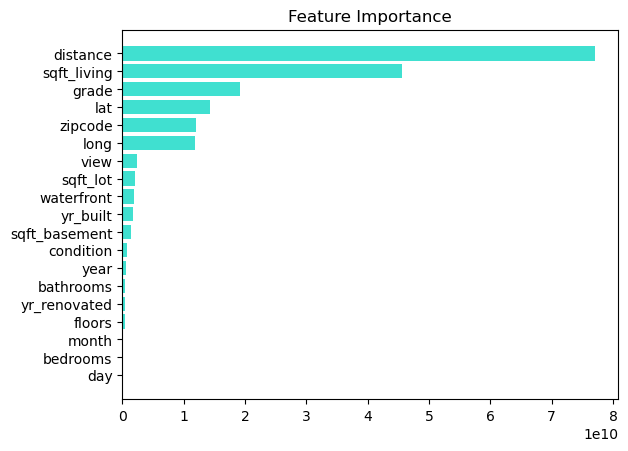

In [12]:
def plot_importance():
    keys = df.drop(['price'], axis=1).columns.tolist() # feature names
    values = [abs(i) for i in importance] # absolute values
    
    dictionary = dict(zip(keys, values))
    scores = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1])}
    
    plt.barh(y=list(scores.keys()), width=list(scores.values()), align='center', color='turquoise')
    plt.title('Feature Importance')
    plt.show()

plot_importance()

Model evaluation results for testing subset.

| RMSE     | RMSLE  | R<sup>2</sup> | Adjusted R<sup>2</sup> | Variance<br>Regression | 5-Fold Cross-<br>Validation |
|----------|--------|---------------|------------------------|------------------------|-----------------------------|
| 110582.6 | 0.7188 | 0.8819        | 0.8812                 | 0.8837                 | 0.8717                      |

To be continued. Final notebook (part 3) will present price estimations achieved with different <code>scikit-learn</code> models.